# Tutorial 6: Complex Components (Embedding Based Search Engine)

In this tutorial, we'll show you how you can build a simple search engine over a dataset, using the CLIP model to drive the search. Users will be able to type in a query to search over images, and will see the dataset images ranked by their similarity to the query.


To get started, run the tutorial demo script.

```{code-block} bash
mk demo match
```

You should see the tutorial app when you open the link in your browser. Let's break down the code in the demo script.

## Installing dependencies
This tutorial has additional dependencies that you need to install. Run the following command to install them.

```{code-block} bash
pip install ftfy regex git+https://github.com/openai/CLIP.git
```

Once you run the script, it will download the CLIP model and cache it in your home directory. This will take a few minutes.

## Loading in the dataset

In [1]:
import meerkat as mk
import rich

The first few lines just load in the `imagenette` dataset, a small 10-class subset of ImageNet.

In [2]:
IMAGE_COLUMN = "img"
df = mk.get("imagenette", version="160px")

In [3]:
EMBED_COLUMN = "img_clip"

# Download the precomupted CLIP embeddings for imagenette.
df_clip = mk.DataFrame.read(
    "https://huggingface.co/datasets/meerkat-ml/meerkat-dataframes/resolve/main/embeddings/imagenette_160px.mk.tar.gz",
    overwrite=False,
)

Downloading:   0%|          | 0.00/114M [00:00<?, ?B/s]

Extracting tar archive, this may take a few minutes...


In [4]:
df = df.merge(df_clip[["img_id", "img_clip"]], on="img_id")

/home/runner/work/meerkat/meerkat/meerkat/ops/merge.py:151: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


,img_id,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid,label_id,label,label_idx,split,img_path,index,img,img_clip
0,n02979186_9036,train/n02979186/n02979186_9036.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,False,n02979186,cassette player,482,train,train/n02979186/n02979186_9036.JPEG,0,,"np.ndarray(shape=(512,))"
1,n02979186_11957,train/n02979186/n02979186_11957.JPEG,n02979186,n02979186,n02979186,n02979186,n03000684,False,n02979186,cassette player,482,train,train/n02979186/n02979186_11957.JPEG,1,,"np.ndarray(shape=(512,))"
2,n02979186_9715,train/n02979186/n02979186_9715.JPEG,n02979186,n02979186,n02979186,n03417042,n03000684,False,n02979186,cassette player,482,train,train/n02979186/n02979186_9715.JPEG,2,,"np.ndarray(shape=(512,))"
3,n02979186_21736,train/n02979186/n02979186_21736.JPEG,n02979186,n02979186,n02979186,n02979186,n03417042,False,n02979186,cassette player,482,train,train/n02979186/n02979186_21736.JPEG,3,,"np.ndarray(shape=(512,))"
4,ILSVRC2012_val_00046953,train/n02979186/ILSVRC2012_val_00046953.JPEG,n02979186,n02979186,n02979186,n02979186,n03394916,False,n02979186,cassette player,482,train,train/n02979186/ILSVRC2012_val_00046953.JPEG,4,,"np.ndarray(shape=(512,))"

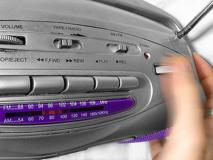
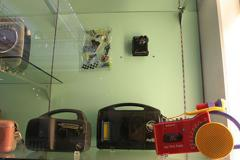
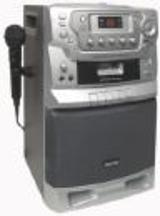
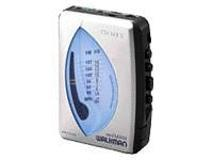
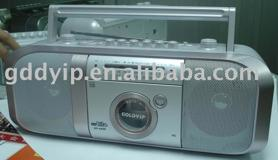

In [5]:
df.head()

## Creating the `Match` component
Now that we have a data frame with the dataset and CLIP image embeddings, we want to be able to run a search over the dataset. To do this, we'll use the `Match` component, which allows us to match a query to the dataset.

In [6]:
match = mk.gui.Match(df, against=EMBED_COLUMN)

Here, `against` is the column in the data frame that we want to match against. In this case, we want to match against the CLIP embeddings.

`Match` is a complex component that does a few things:
- as a component, it visualizes a search bar where users can type in a query
- it provides an endpoint attribute, `on_match`, which can be used to run an endpoint when the user types in a query
- by default, `Match` assigns `on_match` to an endpoint that adds a column to the data frame with the match scores

## Getting the match criteria

When a match query is run, it generates a new column in the data frame with the match scores. The name of this column is stored in the `criterion` attribute of the `Match` component. We can use this to get the name of the match criterion.

Let's use a `magic` context manager to get the name of the match criterion. Using `magic` makes the `match.criterion` Store property accessors reactive, so accessing its `name` attribute will cause this property access to re-run when the criterion is updated.

In [7]:
# Get the name of the match criterion in a reactive way.
with mk.magic():
    criterion_name = match.criterion.name

Now, when a new match query is run, `criterion_name` will be updated to the name of the new match criterion.

## Sorting by match scores
Now that we have the name of the match criterion, we'll use it to sort the data frame by the match scores. We'll use the `mk.sort` function to do this.

We also want sorting to be reactive, so that when a new match query is run, the data frame is sorted by the new match scores. Fortunately, `mk.sort` is a reactive function.

However, before we run `sort`, we need to _mark_ the data frame `df`. Any reactive functions that take `df` as an argument when it is marked will re-run when it is updated.

In [8]:
df.mark()
df_sorted = mk.sort(data=df, by=criterion_name, ascending=False)

With this, we now ensure that when `df` is updated with the new match scores from the user's query, `df_sorted` will be re-sorted by the column with the new match scores.

## Visualizing results in a `Gallery`
Now that we have a sorted data frame, we can visualize the results. Let's use a `Gallery` component to visualize the data frame, and show the images by default.

In [9]:
gallery = mk.gui.Gallery(df_sorted, main_column=IMAGE_COLUMN)

## Putting it all together
With all the pieces, let's put them together into a `Page` and launch the app.
```python
page = mk.gui.Page(
    component=mk.gui.html.flexcol([match, gallery]),
    id="match",
)
page.launch()
```